In [1]:
using StaticArrays, DifferentialEquations, DynamicalSystems
E = 0..30; x = 0..1; y = 0..1
box = E × x × y
using CairoMakie

In [411]:
@inbounds U(y, p) = p[8] + p[9] / ( 1.0 + exp( -50.0 * (y - p[7]) ) )
@inbounds σ(x, p) = 1.0 / ( 1.0 + exp( -20.0 * (x-p[6]) ) )
@inbounds g(E, x, y, p, U_) = log( 1.0 + exp( (p[5] * U_ * x * E + p[11]  ) / (p[1]) ) )

@inbounds function TM(u, p, t)
    
    U_ = U(u[3], p)
    
    du1 = (-u[1] + p[1] * g(u[1], u[2], u[3], p, U_) ) / p[2]
    du2 = (1.0 - u[2]) / p[3] - U_*u[2]*u[1]
    du3 = (-u[3])/p[4] + p[10] * σ(u[2], p)
    
    return SVector(du1, du2, du3)
end
@inbounds function jacob_TM_(u, p, t)
    
    U(y, p, exp50) = p[8] + p[9] / ( 1.0 + exp50 )
    U_y(y, p, exp50) = (50.0 * p[9] * exp50) / (1.0 + exp50)^2
    g(E, x, y, p, U_) = exp((p[5]  * U_ * x * E + p[11]) / p[1])
    σ_der(x, p) = exp( (-20.0) * (x - p[6]) )
    exp50 = exp(-50.0 * (u[3] - p[7]))
    
    U_ = U(u[3], p, exp50)
    Uy = U_y(u[3], p, exp50)
    g_ = g(u[1], u[2], u[3], p, U_)
    σ_deri = σ_der(u[2], p)
    
    g_plus = 1.0 + g_
    g_mult = g_ * U_
    g_plus_mult = p[2] * (g_plus)
    u1p5 = p[5] * u[1]
    Uyu2 = Uy * u[2]
    
    E_E = (-1.0 + ((J * u[2] * g_mult)) / (g_plus) ) / p[2]
    E_x = (u1p5 * g_mult) / (g_plus_mult)
    E_y = (u1p5 * Uyu2 * g_) / (g_plus_mult)
    
    x_E = -U_ * u[2]
    x_x = -1.0 / p[3] - U_ * u[1]
    x_y = -Uyu2 * u[1]
    
    y_x = 20.0 * p[10] * σ_deri / (1.0 + σ_deri)^2
    y_y = -1.0/p[4]
    
    SMatrix{3,3}(E_E, x_E, 0.0,
        E_x, x_x, y_x,
        E_y, x_y, y_y)
end;

In [427]:
const τ = 0.013;  const τD = 0.080;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58;  U0 = 0.25;  const ΔU0 = 0.305; I0 = -1.9;

In [428]:
u0 = [4.59049,   0.83579,   0.839111]

3-element Vector{Float64}:
 4.59049
 0.83579
 0.839111

In [429]:
t = 500; tt = 250; tstep = 0.001
time_attract = 100.0

trange = range(0.0, t, step = tstep)
integ_set = (alg = RK4(), adaptive = false, dt = tstep);

In [430]:
I0range = range(-0.9, -0.99, length = 100)

-0.9:-0.0009090909090909091:-0.99

In [431]:
p = [α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]
ds = CoupledODEs(TM, u0, p, diffeq = integ_set)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  TM
 ODE solver:    RK4
 ODE kwargs:    (adaptive = false, dt = 0.001)
 parameters:    [1.58, 0.013, 0.08, 3.3, 3.07, 0.75, 0.4, 0.25, 0.305, 0.3, -1.9]
 time:          0.0
 state:         [4.59049, 0.83579, 0.839111]


In [432]:
fp, eigs, _ = fixedpoints(ds, box, jacob_TM_, tol = 1e-20);

In [433]:
eigs

3-element Vector{Vector{ComplexF64}}:
 [-17.814198597673045 - 1.8898640523578718im, -17.814198597673045 + 1.8898640523578718im, -0.3030303030303874 + 0.0im]
 [-3.457636167752257 + 0.0im, 1.996424546717588 - 11.231746309918229im, 1.996424546717588 + 11.231746309918229im]
 [-8.06010562946539 + 0.0im, -0.3030303023973595 + 0.0im, 18.681755287451963 + 0.0im]

In [437]:
eigs[1]

3-element Vector{ComplexF64}:
 -17.814198597673045 - 1.8898640523578718im
 -17.814198597673045 + 1.8898640523578718im
 -0.3030303030303874 + 0.0im

In [438]:
fp

3-dimensional StateSpaceSet{Float64} with 3 points
 0.889735  0.961997  0.975938
 7.95576   0.743441  0.462579
 3.87203   0.853302  0.878683

In [439]:
tr, time = trajectory(ds, 500, Δt = tstep)

(3-dimensional StateSpaceSet{Float64} with 500001 points, 0.0:0.001:500.0)

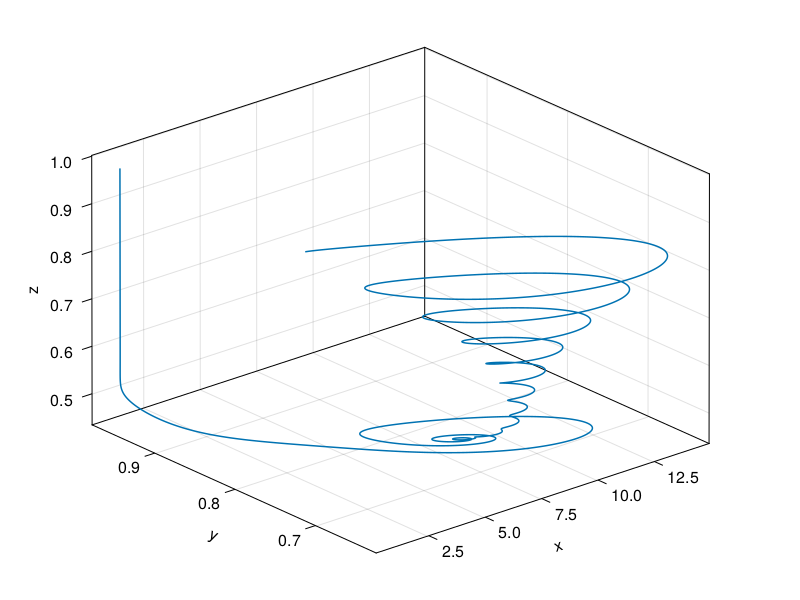

In [440]:
f = Figure()
ts, tf = 1, 300000
ax = Axis3(f[1, 1])
lines!(tr[ts:tf, 1], tr[ts:tf, 2], tr[ts:tf, 3])
f

In [441]:
lyapunovspectrum(ds,t, Ttr = 1000)

3-element Vector{Float64}:
  -0.30303030303755274
 -17.816498416384263
 -17.811898752883632